## Organise all hashtags in a co-ocurrence graph

In [2]:
import pandas as pd
import networkx as nx
from collections import defaultdict
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
ht = pd.read_csv('data/raw/Hashtags.CSV').dropna()
ht.hashtag = ht.hashtag.apply(lambda x: x.lower())
ht.drop_duplicates(inplace=True)
hashtags = ht.hashtag.unique()
print('There are {:,} hashtags from {:,} tweets'.format(len(ht), ht.status_id.nunique()))
ht.sample(5)

There are 20,961,053 hashtags from 7,016,316 tweets


,status_id,hashtag
5621195,1241038791621644289,wakeupclt
17641391,1240089552649441280,democraticcoronavirush
7587853,1241421720671719426,coronavirus
26526572,1238501739084603392,25thamendmentnow
14203996,1240635563230846978,peoplevsschumer


There are 1011257 different hasahtags


Text(0.5, 1.0, 'Value counts of first 200 most common hashtags')

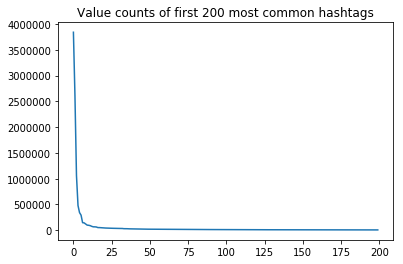

In [4]:
nodes = ht.hashtag.value_counts()
print('There are {:,} different hasahtags'.format(len(nodes)))
first_x = 200
plt.plot(range(first_x), nodes.head(first_x))
plt.title('Value counts of first {} most common hashtags'.format(first_x))

As expected there are some few very common hashtags and a looooong tail. We will never be able to visualise the tail so let's drop all nodes that have less than 5 mentions.

In [11]:
min_size = 1000
nodes = nodes[nodes > min_size]
print('{:,} hashtags were used at least {} times'.format(len(nodes), min_size))

1,392 hashtags were used at least 1000 times


This is still a huge amount but more manageable.

In [12]:
# remove all rare hashtags from the data
# we could also remove all tweets with one node here but I prefer to do it in the next step so as not to wrangle the data twice
ht = ht[ht.hashtag.isin(nodes.index)]
print('{:,} rows need to be collected for edges'.format(len(ht)))

14,879,705 rows need to be collected for edges


In [15]:
# generate edges

grouped = ht.groupby('status_id')
edges = defaultdict(int)

for n, g in grouped:
    h = g.hashtag.values
    if len(h) > 1:
        for h1 in h:
            for h2 in h:
                edges[(h1, h2)] += 1

In [16]:
print('There are {:,} edges'.format(len(edges)))

There are 618,276 edges


Text(0.5, 1.0, 'Degree distribution of the first 200 edges')

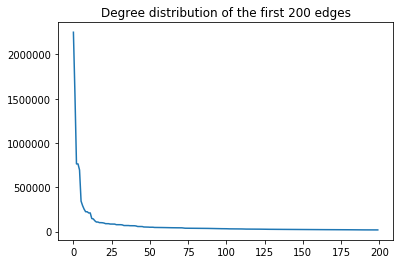

In [17]:
edge_degrees = sorted(edges.values(), reverse=True)
first_x = 200
plt.plot(range(first_x), edge_degrees[:first_x])
plt.title('Degree distribution of the first {} edges'.format(first_x))

In [23]:
# remove all edges that are too weak
min_weight = 1000
edges = {k: v for k, v in edges.items() if v > min_weight}
print('{:,} edges have weight at least {}'.format(len(edges), min_weight))

6,492 edges have weight at least 1000


In [24]:
# create the graph

G = nx.Graph()
for n, size in zip(nodes.index, nodes.values):
    G.add_node(n, size=size)

# add all edges
for k, v in edges.items():
    G.add_edge(*k, weight=v)

In [25]:
# remove isolated
G.remove_nodes_from(list(nx.isolates(G)))

In [26]:
data = nx.readwrite.json_graph.node_link_data(G)

In [67]:
# the json dumps method does not work with this object
with open('networkx_graph_data.json', 'w') as f:
    f.write(str(data).replace('\'', '\"'))

In [66]:
# Create a smaller graph

top_nodes = [x for x,y in G.nodes(data=True) if y['size']> 50000]
small_G = G.subgraph(top_nodes)
data = nx.readwrite.json_graph.node_link_data(small_G)
as_string = str(data).replace('\'', '\"')
with open('networkx_small_graph_data.json', 'w') as f:
    f.write(str(data))